In [1]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve
using ForwardDiff: jacobian, derivative

In [2]:
gr(fmt = :png);

# Model specification

In [3]:
N = 5 # number of firms per cohort
cohorts = (N, N, N) # cohorts
K = length(cohorts) # number of cohorts
q = (1.2, 1.4, 1.6)
f = fill(1/(N+1)^K, (N+1)^K); # awareness set distribution

In [4]:
params = (cohorts = cohorts, Γ_bar = 1.0, Ω = 1.0, q = q, σ = 0.5, κ = 1.5, mc = 0.2)

(cohorts = (5, 5, 5), Γ_bar = 1.0, Ω = 1.0, q = (1.2, 1.4, 1.6), σ = 0.5, κ = 1.5, mc = 0.2)

# Demand function with multiple cohorts

In [5]:
# Demand function with multiple cohorts
# p_i: the price of product of firm i (can be different from p[b])
# b: the cohort firm i belongs to
# p: NK-vector of prices across firms
# f: awareness set distribution
# params: model parameters
function demand(p_i, b, p, f, params)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ = params
    N = cohorts[1]
    K = length(cohorts)
    
    f = reshape(f, Tuple(fill(0:N, K)))
    demand_value = 0
    summand(n) = sum(Tuple(n) .* (p ./ q).^(-1/σ)) 
    for n in CartesianIndices(f)
        if (n[b] > 0)
            demand_value += n[b] * f[n] * (summand(n) + (p_i^(-1/σ) - p[b]^(-1/σ))/(q[b]^(-1/σ)))^(σ*(κ-1)-1)
        end
    end
    demand_value *= Γ_bar^(1-κ)*Ω*(q[b]^(1/σ))*(p_i^(-1/σ-1))
    return demand_value
end

profit(p_i, b, p, f, params) = (p_i - params.mc) * demand(p_i, b, p, f, params)
profit_derivative(p_i, b, p, f, params) = derivative(p_i -> profit(p_i, b, p, f, params), p_i)

profit_derivative (generic function with 1 method)

In [6]:
b = 1 # the cohort firm i belongs to
p = fill(1.0, K); # K-vector of prices

## Plots

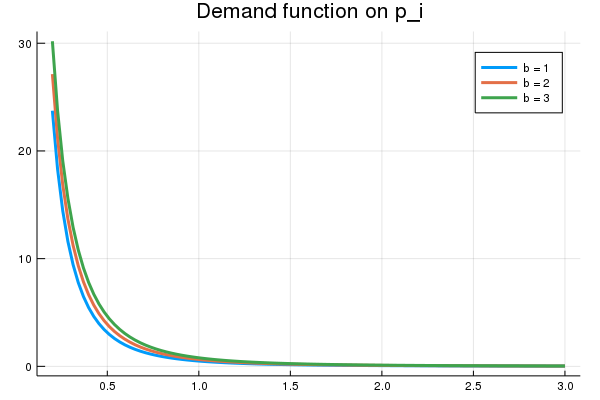

In [7]:
# plot the demand function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> demand(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Demand function on p_i")

In [8]:
# confirm that the demand function is decreasing in price
@assert all(diff((p_i -> demand(p_i, b, p, f, params)).(1:100)) .< 0)

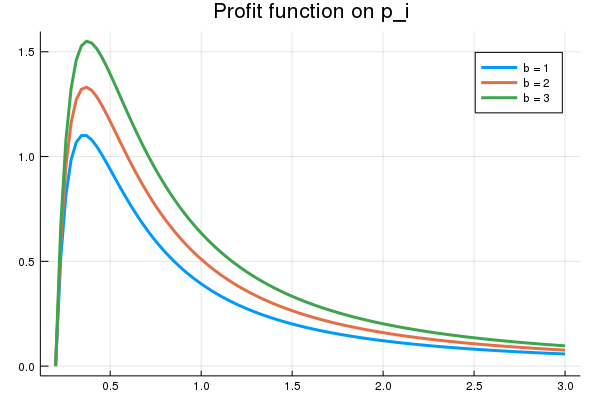

In [9]:
# plot the profit function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i")

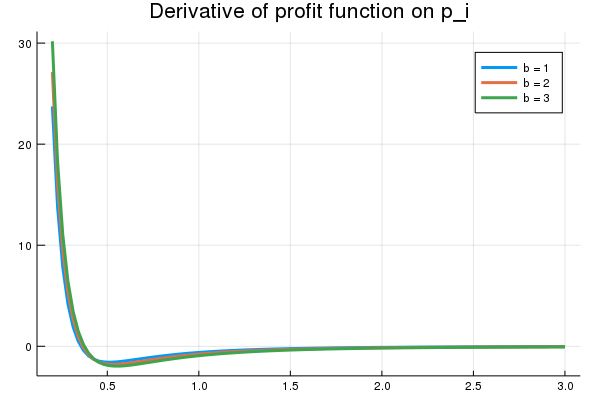

In [10]:
# plot the profit derivative function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> profit_derivative(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Derivative of profit function on p_i")

# Solve Nash equilibria

In [11]:
function p_replace_with_p_i(p)
    p_copy = copy(p)
    p_copy
    return 0
end

function D_p(p, f, params)
    # NK-vector of cohorts where ith element represents ith firms' cohort
    bs = reduce(append!, (b->fill(b,N)).(1:K)) 
    ps = p_replace_with_p_i(p)
    # return the vector of derivatives
    return [profit_derivative(p[i], bs[i], p, f, params) for i in eachindex(p)]
end

function nash_equilibrium(f, params; autodiff=:forward, iv = fill(params.mc, length(params.cohorts)))
    sol = nlsolve(p -> D_p(p, f, params), iv, autodiff = :forward)
    return (p = sol.zero, converged = converged(sol), solution = sol)
end

nash_equilibrium (generic function with 1 method)

In [12]:
p = nash_equilibrium(f, params).p

3-element Array{Float64,1}:
 0.3109958231329776
 0.3109958231329776
 0.3109958231329776

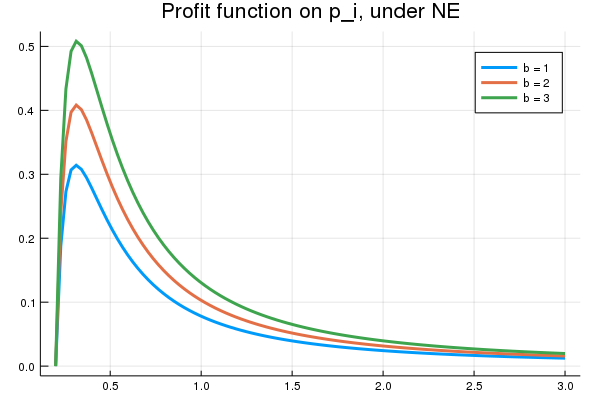

In [13]:
# plot the profit function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")